This file involves preprocessing data a bit, then making a dataloader. The batches are saved to google drive for efficiency later. Finally, the model is created and some training is done. 

I also compute stuff like mean and variance of pixel colours at one point, and also save all the images to google drive so we can look at them.

At the end of the file, I evaluate the final model on every image in the dataset and create a CSV with the second last layer embedding. This embedding is used in another file for the multimodal model.

In [2]:
import pandas as pd

from PIL import Image
import requests
from io import BytesIO

In [3]:
import torch

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from os import listdir

COLUMNS = ["name", "city", "description", "stars", "price", "rating", "reviews", "image", "images",
           "categoryReviews", "userReviews"]
CATEGORIES = ["staff", "facilities", "cleanliness", "comfort", "valueForMoney", "location"]


# reads the file and selects columns
dataframes = []

for file in listdir("/content/drive/MyDrive/Hotel_tensors/new_data/"):
    temp_df = pd.read_json(f"/content/drive/MyDrive/Hotel_tensors/new_data/{file}")
    temp_df["city"] = file[:-12]
    temp_df = temp_df[COLUMNS]
    dataframes.append(temp_df)
df = pd.concat(dataframes)

# create columns based on review categories
for i, var_name in enumerate(CATEGORIES):
    df[var_name] = df["categoryReviews"].str[i].str['score']

# if duplicate or no reviews are available, drop row
df = df[df["reviews"] > 0]
df = df.dropna()
df = df.drop_duplicates(subset=["name", "city"])

# normalize the values of numerical attributes and adjust buggy prices
df.loc[df["price"] < 5, "price"] = 1000 * df.loc[df["price"] < 10, "price"]
for column in ["stars", "reviews", "rating"] + CATEGORIES:
    df[column] = (df[column] - np.mean(df[column])) / np.std(df[column])

# add the one-hot-encoding for cities
df = pd.concat([df, pd.get_dummies(df["city"])], axis=1)

df["price"] = (df["price"]-np.mean(df["price"]))/(np.sqrt(np.var(df["price"])))

# change the price to be in log form
#df["price"] = 1/(1 + np.exp(-df["price"]))

# save it as a csv to be used in other places
#df.to_csv("data.csv", index=False)

df_images = pd.DataFrame().assign(Images=df['image'], Price=df['price'])


data_1 = list(df_images.itertuples(index=False, name=None))

arr = [2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 3, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 3, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 3, 2, 2, 1, 2, 3, 3, 1, 2, 1, 1, 3, 2, 1, 2, 2, 1, 2, 3, 2, 2, 1, 2, 3, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 3, 1, 2, 1, 3, 3, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 3, 3, 2, 1, 1, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 1, 3, 2, 1, 2, 3, 2, 1, 2, 3, 2, 2, 2, 1, 3, 2, 2, 1, 2, 3, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 3, 1, 3, 1, 2, 2, 1, 1, 2, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 3, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 3, 1, 1, 1, 2, 2, 1, 3, 2, 1, 2, 3, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 3, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 3, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 3, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 3, 1, 2, 1, 2, 3, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 3, 2, 2, 2, 2, 2, 3]
arr_2 = [1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 3, 2, 2, 2, 3, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 3, 1, 2, 2, 1, 2, 2, 3, 3, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 3, 2, 3, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 3, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1]
arr_3 = [2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 3, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 3, 2, 2, 1, 2, 1, 2, 2, 1, 3, 3, 1, 2, 3, 2, 2, 2, 2, 2, 1, 3, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 3, 1, 2, 2, 3, 3, 3, 1, 2, 3, 3, 1, 3, 2, 1, 2, 3, 2, 2, 2, 2, 1, 3, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 3, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 3, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 3, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1]
arr_4 = [2, 2, 1, 3, 2, 1, 2, 2, 2, 1, 2, 2, 3, 2, 3, 2, 1, 2, 2, 2, 1, 2, 1, 3, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 3, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 3, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 3, 3, 2, 1, 3]
arr_5 = [2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 3, 2, 1, 2, 2, 2, 1, 2, 2, 2]
arr_6 = [1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 3, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 3, 2]
arr_7 = [2, 1, 2, 2, 2, 3, 2, 1, 2, 3, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 1, 1, 2, 2, 2, 3, 3, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 1, 3, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 3, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2]
arr_8 = [2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 3, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 3, 3, 2, 3, 2, 2, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 3, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 3, 2, 1, 3, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 1, 1, 2, 2, 3, 2, 3, 2, 1, 2, 1, 3, 2, 2, 1, 2, 3, 3, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2]
arr_9 = [1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 3, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 3, 3, 1, 1, 2, 3, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 3, 2, 2, 2, 1, 2, 1, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1]
arr_10 = [2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 1, 1, 2, 1, 2, 2, 1, 3, 2, 1, 2, 1, 3, 2, 1, 2, 1, 1, 1, 2, 2, 2, 3, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 3, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 3, 1, 2, 2, 3, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2]
arr_11 = [1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 3, 2, 1, 2, 3, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 3, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
arr_12 = [1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 3, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2]
arr_13 = [1, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 3, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 3, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2]
arr_14 = [1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 3, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 1, 3, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 3, 2, 1, 2, 2, 2]
arr_15 = [2, 1, 2, 3, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 2, 1, 2, 1, 2, 3, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 3, 2, 2, 2]

prev_len = len(arr)
prev_len_2 = 0
arr = arr + arr_2 + arr_3 + arr_4 + arr_5 + arr_6 + arr_7 + arr_8 + arr_9 + arr_10 + arr_11 + arr_12 + arr_13 + arr_14 + arr_15

arr = arr + [2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1]
arr = arr + [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2]
arr = arr + [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2]
arr = arr + [1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2]
arr = arr + [2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
arr = arr + [2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2]
arr = arr + [2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2]
arr = arr + [2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2]
arr = arr + [1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2]
arr = arr + [2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1]
arr = arr + [1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2]
arr = arr + [1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2]

print(len(arr)) # checks out


numpy_array = np.array(arr)

index_of_2 = np.where(numpy_array == 2)

filtered_df = df.iloc[index_of_2]

filtered_df = filtered_df.drop([49]) # remove incorrectly filtered row

df_images = pd.DataFrame().assign(Images=filtered_df['image'])

link_list = list(df_images['Images'])
  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
4419


In [5]:
from PIL import Image
from tqdm import tqdm

import requests
from io import BytesIO

img_list = []
index_list = []

error_list = []

for i, img in tqdm(enumerate(link_list)):
  try:
    response = requests.get(img)
    img = Image.open(BytesIO(response.content))
    img_list.append(img)
    index_list.append(i)


  except:
    #print("An exception occurred")
    #error_list.append(1)
    pass



3052it [02:00, 25.34it/s]


In [ ]:
data_2 = []
error_list = []

for pair in new_data_list:
  try:
    response = requests.get(pair[0])
    img = Image.open(BytesIO(response.content))
    data_2.append((img, pair[1]))
  except:
    print("An exception occurred")
    error_list.append(1)
    
#print(data_2)
#print(df["Image"])
#print(df["Price"])

An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred


In [ ]:
print(new_data_list)

[('https://cf.bstatic.com/images/hotel/max1024x768/178/178166118.jpg', 1.7613151497339177), ('https://cf.bstatic.com/images/hotel/max1024x768/210/210515906.jpg', 0.7905584724279342), ('https://cf.bstatic.com/images/hotel/max1024x768/433/433890736.jpg', 1.9472047262393188), ('https://cf.bstatic.com/images/hotel/max1024x768/373/373123892.jpg', 0.5082817081049177), ('https://cf.bstatic.com/images/hotel/max1024x768/437/437383768.jpg', 1.91966552972), ('https://cf.bstatic.com/images/hotel/max1024x768/624/62422866.jpg', 1.3000336080353299), ('https://cf.bstatic.com/images/hotel/max1024x768/628/62834770.jpg', 1.045296040231632), ('https://cf.bstatic.com/images/hotel/max1024x768/201/201145897.jpg', 1.568540774098687), ('https://cf.bstatic.com/images/hotel/max1024x768/588/58880849.jpg', 1.045296040231632), ('https://cf.bstatic.com/images/hotel/max1024x768/286/286572013.jpg', 2.5461822505345), ('https://cf.bstatic.com/images/hotel/max1024x768/247/247458851.jpg', 2.945500600064621), ('https://cf.

In [ ]:
print(len(new_data_list))
print(len(arr))
print(prev_len_2)

3072
4419
698


In [ ]:
print(len(error_list))
print(len(data_2))
print(data_2)

63
3009
[(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x7FF3EAF977F0>, 1.7613151497339177), (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x7FF3EAF62FD0>, 0.7905584724279342), (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x698 at 0x7FF3EAF62C70>, 1.9472047262393188), (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x7FF3EAF979D0>, 0.5082817081049177), (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x7FF3EAF979A0>, 1.91966552972), (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x7FF3D99FDC10>, 1.045296040231632), (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x576 at 0x7FF3DA60C3D0>, 1.568540774098687), (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=765x768 at 0x7FF41C0657F0>, 1.045296040231632), (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683 at 0x7FF3DAF3F3D0>, 2.5461822505345), (<PIL.JpegImagePlugin.JpegImageFile image mode=RG

In [ ]:
# Create a folder to save the images
folder_path = '/content/drive/MyDrive/Hotel_tensors/images/'

# Save each image in the array as a separate file in the folder
for i, (img, target) in enumerate(data_2):
    img.save(folder_path + "image_" + str(i) + ".jpg")

In [6]:
print(747 - prev_len_2) # results in 49
# this is an image I incorrectly included, so we will remove it from the dataset

data_2 = data_2[:49] + data_2[49+1 :]

49


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose

# Instantiate the dataset with your own data
dataset = ImageFolder(root='/content/drive/MyDrive/Hotel_images/', transform=Compose([Resize((224, 224)), ToTensor()]))

# Stack all images in the dataset along a new axis
images = np.stack([img.numpy() for img, _ in dataset], axis=0)

# Compute the mean and standard deviation of pixel values across all images and color channels
mean = np.mean(images, axis=(0, 2, 3))
std = np.std(images, axis=(0, 2, 3))

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Mean: [0.58082354 0.5331978  0.49084085]
Standard deviation: [0.24973007 0.25664976 0.27016005]


Mean: [0.58082354 0.5331978  0.49084085]
Standard deviation: [0.24973007 0.25664976 0.27016005]

In [ ]:
import torch
new_data_list = []
df = []
arr = []
torch.cuda.empty_cache()


In [ ]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import necessary libraries
import torch
import torchvision.models as models
import torch.nn as nn

from torchvision.transforms import Resize, Compose, Normalize
from PIL import Image

import csv
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
from os import listdir

import pandas as pd

model = models.vgg16(pretrained = True)

for i, param in enumerate(model.parameters()):
    if i < 24:
        param.requires_grad = False

num_classes = 1  # Assuming scalar labels
model.classifier = nn.Sequential(
    nn.Linear(25088, 256),  # Example FC layer 1
    nn.ReLU(inplace=True),
    nn.Linear(256, 256),  # Example FC layer 2
    nn.ReLU(inplace=True),
    nn.Linear(256, 128),  # Example FC layer 3
    nn.ReLU(inplace=True),
    nn.Linear(128, num_classes)  # Example output layer
)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Set the model to training mode
model.train()

# Define your loss function for regression, e.g., Mean Squared Error (MSE) loss
loss_function = torch.nn.MSELoss()

# Create a custom dataset class
class CustomDataset(ImageFolder):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.data[index]
        #print(img)
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.data)

mean = [0.58082354, 0.5331978, 0.49084085]

std = [0.24973007, 0.25664976, 0.27016005]


train = 0.8
valid = 0.1
test = 0.1

np.random.shuffle(data_2)
train_len = int(len(data_2) * train)
valid_len = int(len(data_2) * valid)
train_set = data_2[:train_len]
valid_set = data_2[train_len:train_len + valid_len]
test_set = data_2[train_len + valid_len:]

# Instantiate the custom dataset with the data and transformation
dataset = CustomDataset(train_set, transform=Compose([Resize((224, 224)), ToTensor(), Normalize(mean, std)]))

# Create a DataLoader with the dataset
dataloader_train = DataLoader(dataset, batch_size=16, shuffle=True) # reduced from 32

# Instantiate the custom dataset with the data and transformation
dataset2 = CustomDataset(valid_set, transform=Compose([Resize((224, 224)), ToTensor(), Normalize(mean, std)]))

# Create a DataLoader with the dataset
dataloader_valid = DataLoader(dataset2, batch_size=16, shuffle=True) # reduced from 32


# Instantiate the custom dataset with the data and transformation
dataset3 = CustomDataset(test_set, transform=Compose([Resize((224, 224)), ToTensor(), Normalize(mean, std)]))

# Create a DataLoader with the dataset
dataloader_test = DataLoader(dataset3, batch_size=16, shuffle=True) # reduced from 32


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: ignored

In [ ]:
for idx, tensor in enumerate(dataloader_train):
    torch.save(tensor, f"{'/content/drive/MyDrive/Test-train-hotels/train_set'}/tensor{idx}.pt")

for idx, tensor in enumerate(dataloader_valid):
    torch.save(tensor, f"{'/content/drive/MyDrive/Test-train-hotels/valid_set'}/tensor{idx}.pt")

for idx, tensor in enumerate(dataloader_test):
    torch.save(tensor, f"{'/content/drive/MyDrive/Test-train-hotels/test_set'}/tensor{idx}.pt")

In [ ]:
# Import necessary libraries
import torch
import torchvision.models as models
import torch.nn as nn

from torchvision.transforms import Resize, Compose, Normalize
from PIL import Image

import csv
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
from os import listdir

import pandas as pd

model = models.vgg16(pretrained = True)


for i, param in enumerate(model.parameters()):
    if i < 16:
        param.requires_grad = False


feats_list = list(model.features)
new_feats_list = []
for feat in feats_list:
    new_feats_list.append(feat)
    if isinstance(feat, nn.Conv2d):
        new_feats_list.append(nn.Dropout(p=0.25, inplace=True))

# modify convolution layers
model.features = nn.Sequential(*new_feats_list)


num_classes = 1  # Assuming scalar labels
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(25088, 512),  # Example FC layer 1
    nn.ReLU(inplace=True),
    #nn.Dropout(p=0.5),
    nn.Linear(512, 256),  # Example FC layer 3
    nn.ReLU(inplace=True),
    #nn.Dropout(p=0.5),
    nn.Linear(256, num_classes)  # Example output layer
    
)



optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.02)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Define your loss function for regression, e.g., Mean Squared Error (MSE) loss
loss_function = torch.nn.MSELoss()

class FolderDataset():
   def __init__(self, folder):
       self.files = listdir(folder)
       self.folder = folder
   def __len__(self):
       return len(self.files)
   def __getitem__(self, idx):
       return torch.load(f"{self.folder}/{self.files[idx]}")

train_folder_data = FolderDataset("/content/drive/MyDrive/Test-train-hotels/train_set")

valid_folder_data = FolderDataset("/content/drive/MyDrive/Test-train-hotels/valid_set")

test_folder_data = FolderDataset("/content/drive/MyDrive/Test-train-hotels/test_set")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

from tqdm import tqdm
import matplotlib.pyplot as plt

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
model = model.to(device)

# Initialize a list to store the loss values
loss_values = []
valid_loss = []

overall_epoch_loss_train = []
overall_epoch_loss_valid = []

num_epochs = 30

# Fine-tune the model on your own regression problem
for epoch in range(num_epochs):  # Number of epochs

    # loss for each epoch
    epoch_loss = 0
    epoch_valid_loss = 0

    model.train()

    # Wrap the dataloader loop with tqdm for a progress bar
    for i in tqdm(range(train_folder_data.__len__()), desc=f"Epoch {epoch + 1}/{num_epochs}"):
        # Get input and target from the batch
        inputs, targets = train_folder_data.__getitem__(i)

        # Convert targets to Float data type and add an extra dimension
        targets = targets.float().unsqueeze(1)

        # Move input and target tensors to the GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = loss_function(outputs, targets)

        loss_values.append(loss.item())
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        #inputs, targets = inputs.cpu(), targets.cpu()
        

        # Update the model parameters
        optimizer.step()

        loss.cpu()
        inputs.cpu()
        targets.cpu()
        outputs.cpu()
        del loss
        del inputs
        del targets
        del outputs
        torch.cuda.empty_cache()

        

    print(epoch_loss/train_folder_data.__len__())
    overall_epoch_loss_train.append(epoch_loss/train_folder_data.__len__())

    del epoch_loss

    model.eval()

    # Iterate over the dataloader
    for i in tqdm(range(valid_folder_data.__len__()), desc=f"Eval Epoch {epoch + 1}/{num_epochs}"):


      # Get the input data and move it to the GPU
      inputs, targets = valid_folder_data.__getitem__(i)
      targets = targets.float().unsqueeze(1)

      inputs, targets = inputs.to(device), targets.to(device)

      # Pass the input data through the model and get the predicted output
      outputs = model(inputs)

      loss = loss_function(outputs, targets)

      valid_loss.append(loss.item())
      epoch_valid_loss += loss.item()

      #inputs, targets = inputs.cpu(), targets.cpu()


      loss.cpu()
      inputs.cpu()
      targets.cpu()
      outputs.cpu()
      del loss
      del inputs
      del targets
      del outputs

      torch.cuda.empty_cache()


    print(epoch_valid_loss/valid_folder_data.__len__())
    overall_epoch_loss_valid.append(epoch_valid_loss/valid_folder_data.__len__())

    del epoch_valid_loss

# Plot the training loss curve
plt.figure()
plt.plot(np.linspace(1, len(loss_values), len(loss_values)), np.sqrt(loss_values))
plt.plot(np.linspace(1, len(loss_values), len(valid_loss)), np.sqrt(valid_loss))
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.ylim(0, 5)
plt.title('Training Loss Curve')

plt.legend(['Training loss', 'Validation loss'])

plt.show


# Plot the training loss curve
plt.figure()
plt.plot(np.sqrt(overall_epoch_loss_train))
plt.plot(np.sqrt(overall_epoch_loss_valid))
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.ylim(0, 5)
plt.title('Training Loss Curve')

plt.legend(['Training loss', 'Validation loss'])

plt.show


Epoch 1/30: 100%|██████████| 151/151 [00:23<00:00,  6.37it/s]


52615291083551.336


Eval Epoch 1/30:  63%|██████▎   | 12/19 [00:01<00:00, 10.35it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

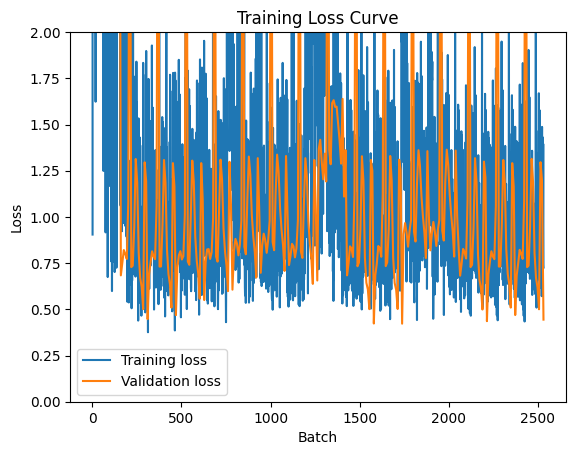

In [ ]:
# Plot the training loss curve
plt.plot(np.linspace(1, len(loss_values), len(loss_values)), np.sqrt(loss_values))
plt.plot(np.linspace(1, len(loss_values), len(valid_loss)), np.sqrt(valid_loss))
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.ylim(0, 2)
plt.title('Training Loss Curve')

plt.legend(['Training loss', 'Validation loss'])

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

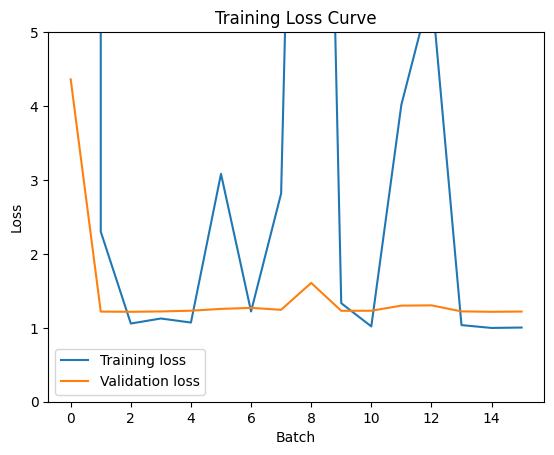

In [ ]:
# Plot the training loss curve
plt.figure()
plt.plot(np.sqrt(overall_epoch_loss_train))
plt.plot(np.sqrt(overall_epoch_loss_valid))
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.ylim(0, 5)
plt.title('Training Loss Curve')

plt.legend(['Training loss', 'Validation loss'])

plt.show


In [ ]:
imgs, labels = train_folder_data.__getitem__(0)

16


In [ ]:
# clean out RAM
train_set = []
valid_set = []
data_2 = []
torch.cuda.empty_cache()

del data_2
del train_set
del valid_set

In [ ]:
for i, param in enumerate(model.parameters()):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


1
6
7
9
12
25
91


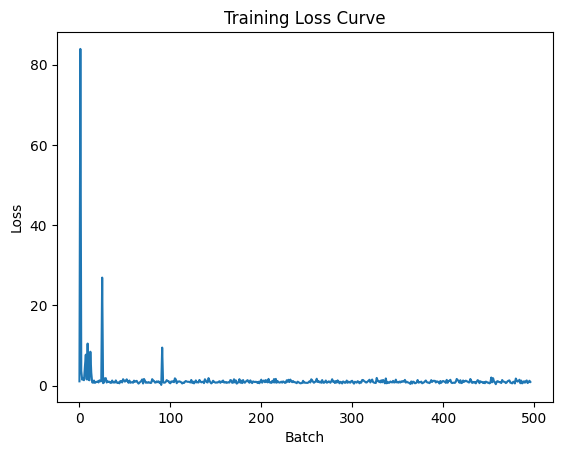

In [ ]:
plt.plot(np.sqrt(loss_values))
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show

for i in range(len(loss_values)):
  if loss_values[i] > 20:
    print(i)


In [ ]:
print(np.sqrt(loss_values[-1]))
print(loss_values[-1])
print(valid_loss[-1])

0.11560678879853027
0.013364929616307983
0.8165612809168987


In [ ]:
# Set the model to evaluation mode
model.eval()

# Create an empty list to store the predicted outputs
predictions = []

# Instantiate the custom dataset with the data and transformation
dataset = CustomDataset(valid_set, transform=Compose([Resize((224, 224)), ToTensor(), Normalize(mean, std)]))

# Create a DataLoader with the dataset
dataloader_valid = DataLoader(dataset, batch_size=16, shuffle=True) # reduced from 32

# Iterate over the dataloader
for batch in tqdm(dataloader_valid):
    # Get the input data and move it to the GPU
    inputs, _ = batch
    inputs = inputs.to(device)

    # Pass the input data through the model and get the predicted output
    outputs = model(inputs)

    # Move the predicted output back to the CPU and append it to the list of predictions
    predictions.append(outputs.to('cpu'))

# Concatenate the predictions into a single tensor
predictions = torch.cat(predictions, dim=0)

# Convert the tensor to a numpy array and flatten it if necessary
predictions = predictions.detach().numpy().flatten()

# Get the true labels from the dataset
true_labels = np.array([label for _, label in valid_set])

# Compute the Mean Squared Error
mse = np.mean((predictions - true_labels)**2)

print(f"Mean Squared Error: {mse:.4f}")


'''
img, label = data_2[-1]

img.show()
print(label)

transform = Compose([Resize((224, 224)), ToTensor()])

input_tensor = transform(img)

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_tensor = input_tensor.to(device)

print(input_tensor)

output = model(input_tensor)  # Get the output from the model
'''

100%|██████████| 39/39 [00:09<00:00,  3.90it/s]

Mean Squared Error: 1.5173


'\nimg, label = data_2[-1]\n\nimg.show()\nprint(label)\n\ntransform = Compose([Resize((224, 224)), ToTensor()])\n\ninput_tensor = transform(img)\n\n#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\n\ninput_tensor = input_tensor.to(device)\n\nprint(input_tensor)\n\noutput = model(input_tensor)  # Get the output from the model\n'

In [ ]:
model.head.in_features

In [ ]:
print(model.head.in_features)

AttributeError: ignored

In [ ]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import torch
import torchvision.models as models
import torch.nn as nn

from torchvision.transforms import Resize, Compose, Normalize
from PIL import Image

import csv
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
from os import listdir

import pandas as pd

from tqdm import tqdm

model = models.vgg16(pretrained = True)

num_classes = 1  # Assuming scalar labels
model.classifier = nn.Sequential(
    nn.Linear(25088, 2048),  # Example FC layer 1
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.25),
    nn.Linear(2048, 2048),  # Example FC layer 3
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.25),
    nn.Linear(2048, num_classes)  # Example output layer
)

checkpoint = torch.load("/content/drive/MyDrive/test-validation-train/CNN.pt")
model.load_state_dict(checkpoint)

# Remove the last 2 layers
model.classifier = nn.Sequential(*list(model.classifier.children())[:-2])  


'''
# Create a custom dataset class
class CustomDataset(ImageFolder):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.data[index]
        #print(img)
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.data)

'''

class CustomDataset(ImageFolder):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        img = self.data[index]
        if self.transform:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.data)

mean = [0.58082354, 0.5331978, 0.49084085]

std = [0.24973007, 0.25664976, 0.27016005]


# Instantiate the custom dataset with the data and transformation
dataset = CustomDataset(img_list, transform=Compose([Resize((224, 224)), ToTensor(), Normalize(mean, std)]))

# Create a DataLoader with the dataset
dataloader = DataLoader(dataset, batch_size=16, shuffle=False) # reduced from 32


# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
model = model.to(device)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
import sys

for i, batch in enumerate(dataloader):
  if i >= 1:
    break
  else:
    inputs = batch
    inputs = inputs.to(device)
    out = model(inputs)
    print(out.data[0])
    print(len(out.data[0]))


tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0093], device='cuda:0')
2048


In [7]:
from csv import writer




model.eval()

for batch in tqdm(dataloader):

      # Get the input data and move it to the GPU
      inputs = batch

      inputs = inputs.to(device)

      for i in range(16):
        # Pass the input data through the model and get the predicted output
        #out_arr.append(model(inputs).data[i])

        with open('/content/drive/MyDrive/Test-train-hotels/image_feature_array.csv', 'a') as f_object:
          writer_object = writer(f_object)
          writer_object.writerow(model(inputs).data[i])
          f_object.close()
      

      #inputs.cpu()
      #del inputs

      torch.cuda.empty_cache()

 99%|█████████▉| 186/187 [37:03<00:11, 11.95s/it]


IndexError: ignored

In [ ]:
df = pd.DataFrame(out_arr)
df.to_csv("/content/drive/MyDrive/Test-train-hotels/image_feature_array.csv")

In [ ]:
#filtered_df = filtered_df.iloc[index_list]

out_arr = [elt.cpu() for elt in out_arr]

filtered_df["Img_Features"] = out_arr

filtered_df.to_csv("/content/drive/MyDrive/Test-train-hotels/image_feature_array.csv")

